## 4.3 컬러 이미지를 분류하는 CNN 구현
CNN을 이용해 사진을 분류하는 방법을 다룹니다.

### 4.3.1 분류 CNN 패키지 임포트

In [1]:
# set to use CPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

1. 필요한 패키지들을 임포트합니다.

In [2]:
from sklearn import model_selection, metrics
from sklearn.preprocessing import MinMaxScaler

- 유용한 기능을 제공하는 다른 파이썬 패키지도 임포트합니다.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

- 케라스 모델링을 위한 서브패키지들을 불러옵니다.

In [4]:
from keras import backend as K
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

- 케라스를 편리하게 사용하기 위해 여기서 만든 2가지 모듈을 불러옵니다.

In [5]:
from keraspp import skeras
from keraspp import sfile

### 4.3.2 분류 CNN 모델링

2. 분류 CNN 모델링을 만듭니다.

In [6]:
# 2. 분류 CNN 모델링
class CNN(Model):
    def __init__(self, nb_classes): 
        super(CNN,self).__init__() 
        self.nb_classes = nb_classes
        
        self.conv2D_A = Conv2D(32, kernel_size=(3, 3), activation='relu')
        self.conv2D_B = Conv2D(64, (3, 3), activation='relu')
        self.maxPooling2D_A = MaxPooling2D(pool_size=(2, 2))
        self.dropout_A = Dropout(0.25)
        self.flatten = Flatten()
        
        self.dense_A = Dense(128, activation='relu')
        self.dropout_B = Dropout(0.5)
        self.dense_B = Dense(nb_classes, activation='softmax', name='preds')
        
    def call(self, x):
        h = self.conv2D_A(x)
        h = self.conv2D_B(h)
        h = self.maxPooling2D_A(h)
        h = self.dropout_A(h)
        h = self.flatten(h)

        h = self.dense_A(h)
        h = self.dropout_B(h)

        y = self.dense_B(h)
        
        return y

In [4]:
nb_classes = 10
model = CNN(nb_classes=nb_classes)
model.compile(loss='categorical_crossentropy',
                      optimizer='adadelta', metrics=['accuracy'])

### 4.3.3 분류 CNN을 위한 데이터 준비

3. 주어진 데이터를 해당 머신러닝에 사용하기 적합하도록 조정하는 기능을 하는 DataSet 클래스를 만듭니다.

In [4]:
# 3. 분류 CNN을 위한 데이터 준비
class DataSet:
    def __init__(self, X, y, nb_classes, scaling=True, 
                 test_size=0.2, random_state=0):
        self.X = X
        self.add_channels()
        X = self.X
        
        # the data, shuffled and split between train and test sets
        X_train, X_test, y_train, y_test = model_selection.train_test_split(
            X, y, test_size=0.2, random_state=random_state)

        print(X_train.shape, y_train.shape)

        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')

        if scaling:
            # scaling to have (0, 1) for each feature (each pixel)
            scaler = MinMaxScaler()
            n = X_train.shape[0]
            X_train = scaler.fit_transform(
                X_train.reshape(n, -1)).reshape(X_train.shape)
            n = X_test.shape[0]
            X_test = scaler.transform(
                X_test.reshape(n, -1)).reshape(X_test.shape)
            self.scaler = scaler

        print('X_train shape:', X_train.shape)
        print(X_train.shape[0], 'train samples')
        print(X_test.shape[0], 'test samples')

        # convert class vectors to binary class matrices
        Y_train = np_utils.to_categorical(y_train, nb_classes)
        Y_test = np_utils.to_categorical(y_test, nb_classes)

        self.X_train, self.X_test = X_train, X_test
        self.Y_train, self.Y_test = Y_train, Y_test
        self.y_train, self.y_test = y_train, y_test

    def add_channels(self):
        X = self.X

        if len(X.shape) == 3:
            N, img_rows, img_cols = X.shape

            if K.image_dim_ordering() == 'th':
                X = X.reshape(X.shape[0], 1, img_rows, img_cols)
                input_shape = (1, img_rows, img_cols)
            else:
                X = X.reshape(X.shape[0], img_rows, img_cols, 1)
                input_shape = (img_rows, img_cols, 1)
        else:
            input_shape = X.shape[1:]  # channel is already included.

        self.X = X
        self.input_shape = input_shape

In [5]:
from keras import datasets
(X, y), (x_test, y_test) = datasets.cifar10.load_data()
nb_classes = 10
data = DataSet(X, y, nb_classes)
print('data.input_shape', data.input_shape)

(40000, 32, 32, 3) (40000, 1)
X_train shape: (40000, 32, 32, 3)
40000 train samples
10000 test samples
data.input_shape (32, 32, 3)


In [6]:
epochs=2
batch_size=128
verbose=1
history = model.fit(data.X_train, data.Y_train, 
                    batch_size=batch_size, epochs=epochs,
                    verbose=verbose, 
                    validation_data=(data.X_test, data.Y_test))

Epoch 1/2
313/313 [==============================] - 47s 150ms/step - loss: 2.3076 - accuracy: 0.1087 - val_loss: 2.2870 - val_accuracy: 0.1377
Epoch 2/2
313/313 [==============================] - 49s 158ms/step - loss: 2.2918 - accuracy: 0.1227 - val_loss: 2.2746 - val_accuracy: 0.1754


### 4.3.4 분류 CNN의 학습 및 성능 평가를 위한 머신 클래스

4. 학습 및 성능 평가를 쉽게 수행할 수 있는 상위 개념 클래스인 Machine을 만듭니다. 

In [7]:
# 4. 분류 CNN의 학습 및 성능 평가를 위한 머신 클래스
class Machine():
    def __init__(self, X, y, nb_classes=2, fig=True):
        self.nb_classes = nb_classes
        self.set_data(X, y)
        self.set_model()
        self.fig = fig

    def set_data(self, X, y):
        nb_classes = self.nb_classes
        self.data = DataSet(X, y, nb_classes)
        print('data.input_shape', self.data.input_shape)

    def set_model(self):
        nb_classes = self.nb_classes
        data = self.data
        self.model = CNN(nb_classes=nb_classes)
        self.model.compile(loss='categorical_crossentropy',
                      optimizer='adadelta', metrics=['accuracy'])        

    def fit(self, epochs=10, batch_size=128, verbose=1):
        data = self.data
        model = self.model

        history = model.fit(data.X_train, data.Y_train, 
                            batch_size=batch_size, epochs=epochs,
                            verbose=verbose, 
                            validation_data=(data.X_test, data.Y_test))
        return history

    def run(self, epochs=100, batch_size=128, verbose=1):
        data = self.data
        model = self.model
        fig = self.fig

        history = self.fit(epochs=epochs,
                           batch_size=batch_size, verbose=verbose)

        score = model.evaluate(data.X_test, data.Y_test, verbose=0)

        print('Confusion matrix')
        Y_test_pred = model.predict(data.X_test, verbose=0)
        y_test_pred = np.argmax(Y_test_pred, axis=1)
        print(metrics.confusion_matrix(data.y_test, y_test_pred))

        print('Test score:', score[0])
        print('Test accuracy:', score[1])

        # Save results
        suffix = sfile.unique_filename('datatime')
        foldname = 'output_' + suffix
        os.makedirs(foldname)
        skeras.save_history_history(
            'history_history.npy', history.history, fold=foldname)
        model.save_weights(os.path.join(foldname, 'dl_model.h5'))
        print('Output results are saved in', foldname)

        if fig:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            skeras.plot_acc(history)
            plt.subplot(1, 2, 2)
            skeras.plot_loss(history)
            plt.show()

        self.history = history

        return foldname

---
### 4.3.5 분류 CNN을 처리하는 머쉰의 전체 코드

In [10]:
# File - keraspp/aicnn.py

# 1. 분류 CNN 패키지 임포트 
from sklearn import model_selection, metrics
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import os

from keras import backend as K
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from keraspp import skeras
from keraspp import sfile

# 2. 분류 CNN 모델링
class CNN(Model):
    def __init__(self, nb_classes): #, in_shape=None):
        super(CNN,self).__init__() # added 2021-10-01
        self.nb_classes = nb_classes
        #self.in_shape = in_shape
        
        self.conv2D_A = Conv2D(32, kernel_size=(3, 3), activation='relu')
        self.conv2D_B = Conv2D(64, (3, 3), activation='relu')
        self.maxPooling2D_A = MaxPooling2D(pool_size=(2, 2))
        self.dropout_A = Dropout(0.25)
        self.flatten = Flatten()
        
        self.dense_A = Dense(128, activation='relu')
        self.dropout_B = Dropout(0.5)
        self.dense_B = Dense(nb_classes, activation='softmax', name='preds')
        
    def call(self, x):
        nb_classes = self.nb_classes
        # in_shape = self.in_shape

        #x = Input(in_shape)

        h = self.conv2D_A(x)
        h = self.conv2D_B(h)
        h = self.maxPooling2D_A(h)
        h = self.dropout_A(h)
        h = self.flatten(h)

        h = self.dense_A(h)
        h = self.dropout_B(h)

        y = self.dense_B(h)
        
        return y

# 3. 분류 CNN을 위한 데이터 준비
class DataSet:
    def __init__(self, X, y, nb_classes, scaling=True, 
                 test_size=0.2, random_state=0):
        """
        X is originally vector. Hence, it will be transformed
        to 2D images with a channel (i.e, 3D).
        """
        self.X = X
        self.add_channels()

        X = self.X
        # the data, shuffled and split between train and test sets
        X_train, X_test, y_train, y_test = model_selection.train_test_split(
            X, y, test_size=0.2, random_state=random_state)

        print(X_train.shape, y_train.shape)

        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')

        if scaling:
            # scaling to have (0, 1) for each feature (each pixel)
            scaler = MinMaxScaler()
            n = X_train.shape[0]
            X_train = scaler.fit_transform(
                X_train.reshape(n, -1)).reshape(X_train.shape)
            n = X_test.shape[0]
            X_test = scaler.transform(
                X_test.reshape(n, -1)).reshape(X_test.shape)
            self.scaler = scaler

        print('X_train shape:', X_train.shape)
        print(X_train.shape[0], 'train samples')
        print(X_test.shape[0], 'test samples')

        # convert class vectors to binary class matrices
        Y_train = np_utils.to_categorical(y_train, nb_classes)
        Y_test = np_utils.to_categorical(y_test, nb_classes)

        self.X_train, self.X_test = X_train, X_test
        self.Y_train, self.Y_test = Y_train, Y_test
        self.y_train, self.y_test = y_train, y_test
        # self.input_shape = input_shape

    def add_channels(self):
        X = self.X

        if len(X.shape) == 3:
            N, img_rows, img_cols = X.shape

            if K.image_dim_ordering() == 'th':
                X = X.reshape(X.shape[0], 1, img_rows, img_cols)
                input_shape = (1, img_rows, img_cols)
            else:
                X = X.reshape(X.shape[0], img_rows, img_cols, 1)
                input_shape = (img_rows, img_cols, 1)
        else:
            input_shape = X.shape[1:]  # channel is already included.

        self.X = X
        self.input_shape = input_shape    
    
# 4. 분류 CNN의 학습 및 성능 평가를 위한 머신 클래스
class Machine():
    def __init__(self, X, y, nb_classes=2, fig=True):
        self.nb_classes = nb_classes
        self.set_data(X, y)
        self.set_model()
        self.fig = fig

    def set_data(self, X, y):
        nb_classes = self.nb_classes
        self.data = DataSet(X, y, nb_classes)
        print('data.input_shape', self.data.input_shape)

    def set_model(self):
        nb_classes = self.nb_classes
        data = self.data
        self.model = CNN(nb_classes=nb_classes)
        self.model.compile(loss='categorical_crossentropy',
                      optimizer='adadelta', metrics=['accuracy'])        

    def fit(self, epochs=10, batch_size=128, verbose=1):
        data = self.data
        model = self.model

        history = model.fit(data.X_train, data.Y_train, 
                            batch_size=batch_size, epochs=epochs,
                            verbose=verbose, 
                            validation_data=(data.X_test, data.Y_test))
        return history

    def run(self, epochs=100, batch_size=128, verbose=1):
        data = self.data
        model = self.model
        fig = self.fig

        history = self.fit(epochs=epochs,
                           batch_size=batch_size, verbose=verbose)

        score = model.evaluate(data.X_test, data.Y_test, verbose=0)

        print('Confusion matrix')
        Y_test_pred = model.predict(data.X_test, verbose=0)
        y_test_pred = np.argmax(Y_test_pred, axis=1)
        print(metrics.confusion_matrix(data.y_test, y_test_pred))

        print('Test score:', score[0])
        print('Test accuracy:', score[1])

        # Save results
        suffix = sfile.unique_filename('datatime')
        foldname = 'output_' + suffix
        os.makedirs(foldname)
        skeras.save_history_history(
            'history_history.npy', history.history, fold=foldname)
        model.save_weights(os.path.join(foldname, 'dl_model.h5'))
        print('Output results are saved in', foldname)

        if fig:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            skeras.plot_acc(history)
            plt.subplot(1, 2, 2)
            skeras.plot_loss(history)
            plt.show()

        self.history = history

        return foldname

### 4.3.6 분류 CNN의 학습 및 성능 평가 수행

5. 분류 CNN을 위한 머쉰에 기반하여 컬러 이미지를 분류합니다.

In [ ]:
# 5. 분류 CNN의 학습 및 성능 평가 수행
from keras import datasets
import keras
assert keras.backend.image_data_format() == 'channels_last'

# from keraspp import aicnn
class MyMachine(Machine):
    def __init__(self):
        (X, y), (x_test, y_test) = datasets.cifar10.load_data()
        super(MyMachine,self).__init__(X, y, nb_classes=10)

def main():
    m = MyMachine()
    m.run(epochs=2)

main()

---
### 4.3.7 분류 CNN의 수행을 위한 전체 코드

(40000, 32, 32, 3) (40000, 1)
X_train shape: (40000, 32, 32, 3)
40000 train samples
10000 test samples
data.input_shape (32, 32, 3)


2021-10-02 10:40:34.941649: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-02 10:40:35.254109: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-02 10:40:35.254269: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (SJKIM-Home): /proc/driver/nvidia/version does not exist
2021-10-02 10:40:35.258540: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-10-02 10:40:35.317358: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3599995000 Hz
2021-10-02 10:40:35.318876: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b81145d7a0 initialized for platform Host (this does not guarantee that XLA will be used). Devi

Epoch 1/2
313/313 [==============================] - 53s 169ms/step - loss: 2.3125 - accuracy: 0.1060 - val_loss: 2.2920 - val_accuracy: 0.1183
Epoch 2/2
313/313 [==============================] - 56s 179ms/step - loss: 2.2973 - accuracy: 0.1148 - val_loss: 2.2812 - val_accuracy: 0.1192
Confusion matrix
[[839   2   0   6   0   1   0   6 147   3]
 [621   0   0  12   1  11   0  19 309  13]
 [747   4   0   9   0  19   0  23 205   9]
 [576   4   0  38   0  46   0  33 325   8]
 [627   1   0  35   0  22   0  20 258   4]
 [642   1   0  28   0  29   0  28 280   8]
 [480   1   0  35   0  43   0  53 333   8]
 [682   3   0  15   0  22   1  28 231  17]
 [755   2   0   3   0   0   0   2 223   4]
 [726   8   0   1   0   8   0  10 252  35]]
Test score: 2.281205415725708
Test accuracy: 0.11919999867677689
Output results are saved in output_37ca986a-8f98-4cab-9d67-89b863ea66e0


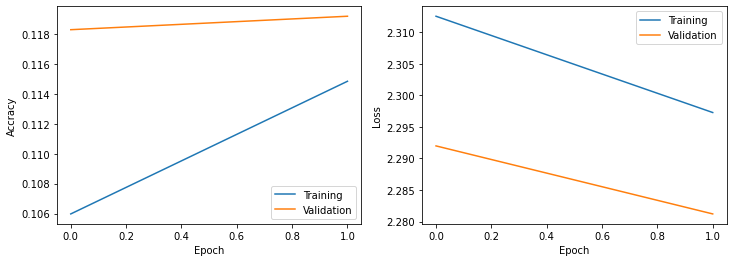

In [9]:
# File - ex4_2_cnn_ficar10_cl-cpu.py

# set to use CPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# 5. 분류 CNN의 학습 및 성능 평가 수행
from keras import datasets
import keras
assert keras.backend.image_data_format() == 'channels_last'
from keraspp import aicnn

# from keraspp import aicnn
class MyMachine(aicnn.Machine):
    def __init__(self):
        (X, y), (x_test, y_test) = datasets.cifar10.load_data()
        super(MyMachine,self).__init__(X, y, nb_classes=10)

def main():
    m = MyMachine()
    m.run(epochs=2)

main()